<a href="https://colab.research.google.com/github/N2000-hack/Music_Genre_Classification_Project/blob/main/Music_Genre_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [16]:
import pandas as pd

In [3]:
#!pip install xgboost -U
!pip uninstall xgboost
!pip install xgboost==0.90
!pip install librosa -U
!pip install hyperopt

Found existing installation: xgboost 2.1.3
Uninstalling xgboost-2.1.3:
  Would remove:
    /usr/local/lib/python3.10/dist-packages/xgboost-2.1.3.dist-info/*
    /usr/local/lib/python3.10/dist-packages/xgboost.libs/libgomp-24e2ab19.so.1.0.0
    /usr/local/lib/python3.10/dist-packages/xgboost/*
Proceed (Y/n)? y
  Successfully uninstalled xgboost-2.1.3
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 142.8/142.8 MB 6.8 MB/s eta 0:00:00


In [4]:
import warnings
warnings.simplefilter("ignore", UserWarning)
import os
from tqdm import tqdm
import pickle
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import librosa
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import RFECV,mutual_info_regression
from sklearn.metrics import confusion_matrix, accuracy_score,classification_report
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.decomposition import PCA
from xgboost import XGBClassifier

In [5]:
df = pd.read_csv('/content/drive/MyDrive/Music_Genre_Classification_Project/refined_csv.csv')
df.head()

,s.no,label,chroma_cens_mean,chroma_cens_var,spectral_contrast_mean,spectral_contrast_var,spectral_flatness_mean,spectral_flatness_var,tonnetz_mean,tonnetz_var,...,mfccs2_mean,mfccs2_var,mfccs3_mean,mfccs3_var,mfccs4_mean,mfccs4_var,mfccs5_mean,mfccs5_var,mfccs6_mean,mfccs6_var
0,1,blues,0.272263,0.009206,20.523289,76.801191,0.004496,0.000030,0.006427,0.004310,...,0.729792,1201.604492,0.643018,919.671143,0.427209,743.078430,0.278182,623.940552,0.075146,538.383850
1,2,blues,0.261079,0.015171,20.672486,67.861845,0.002298,0.000023,0.029378,0.004747,...,-0.191769,2427.744385,-0.095275,1839.843018,-0.447561,1480.468994,-0.362621,1239.792358,-0.517989,1067.379395
2,3,blues,0.262717,0.014313,22.191292,76.122598,0.002635,0.000011,0.024226,0.010467,...,-0.242961,1260.250732,-0.848506,960.121521,-0.798550,779.632996,-0.909575,656.125000,-0.734296,566.632812
3,4,blues,0.226096,0.032214,21.423621,63.386763,0.000955,0.000003,0.026663,0.017942,...,-0.917738,2388.502930,-1.725891,1800.508911,-2.034785,1447.093750,-2.367971,1211.789917,-2.301722,1042.670654
4,5,blues,0.259727,0.015875,21.459618,63.033892,0.003240,0.000019,-0.020944,0.010100,...,-5.902440,1791.375977,-4.868073,1365.617676,-4.242023,1104.110596,-3.698091,931.020142,-3.299158,802.696533


<Axes: >

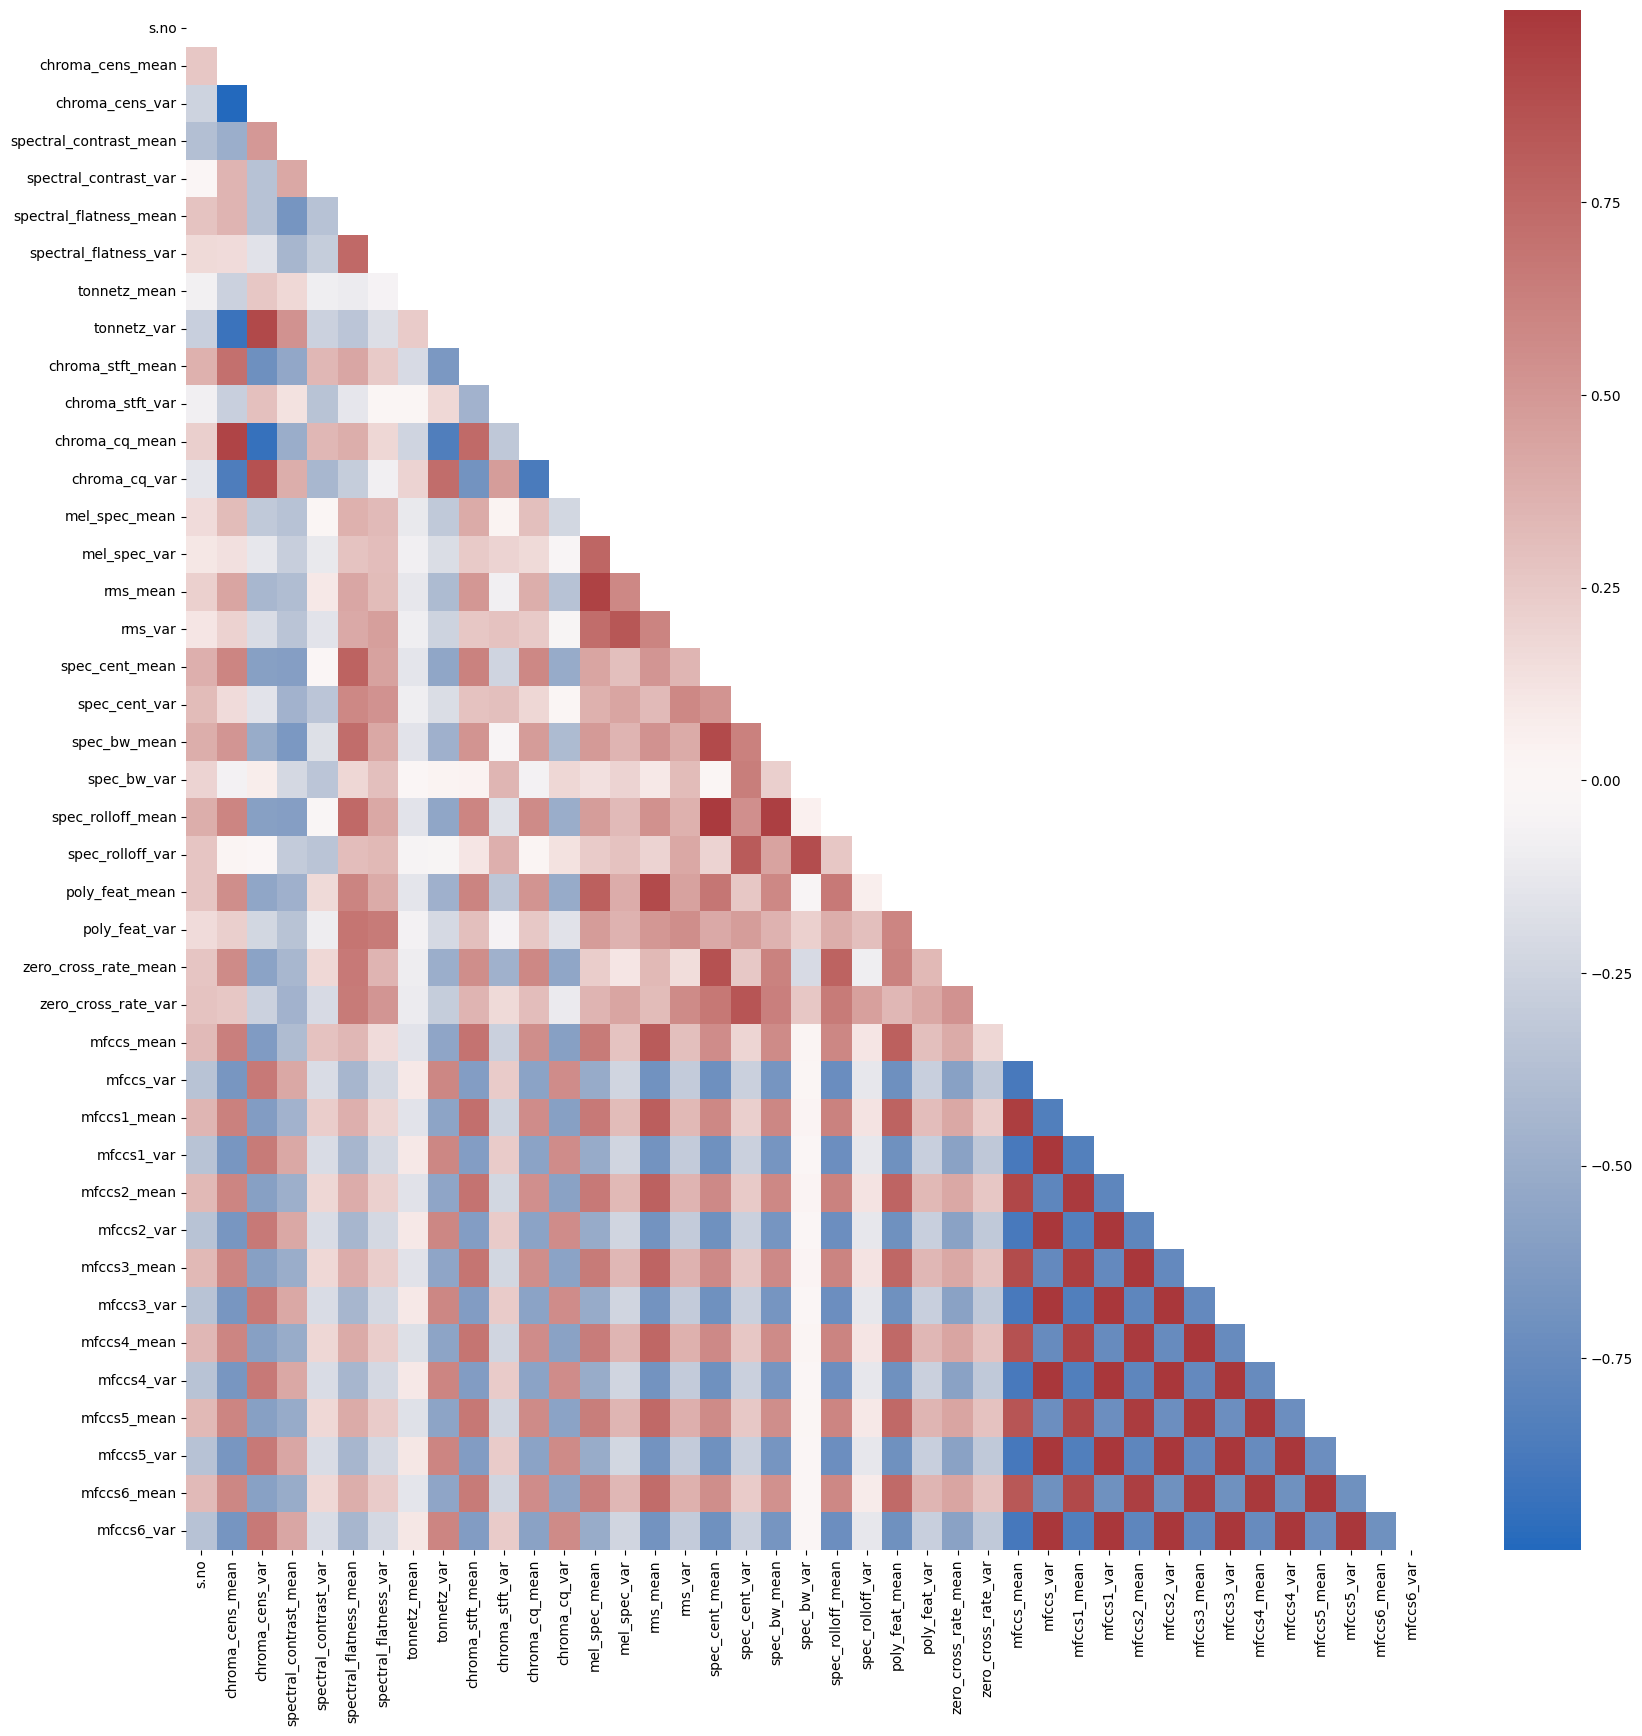

In [7]:
#corr = df.corr()
corr = df.select_dtypes(include=np.number).corr()

mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True

plt.subplots(figsize=(20, 20))
sns.heatmap(corr, mask=mask, cmap="vlag")

In [11]:
sol = (corr.where(np.triu(np.ones(corr.shape), k=1).astype(bool))
                  .stack()
                  .sort_values(ascending=False))
for index, value in sol.items():
    if (value > 0.75) or (value < -0.75):
        print(index, value)

('mfccs5_var', 'mfccs6_var') 0.9999936679547573
('mfccs4_var', 'mfccs5_var') 0.9999910712394249
('mfccs3_var', 'mfccs4_var') 0.9999893677149928
('mfccs2_var', 'mfccs3_var') 0.9999771822769423
('mfccs4_var', 'mfccs6_var') 0.9999740726057749
('mfccs3_var', 'mfccs5_var') 0.9999659601771236
('mfccs1_var', 'mfccs2_var') 0.9999596953812807
('mfccs2_var', 'mfccs4_var') 0.9999423946436026
('mfccs3_var', 'mfccs6_var') 0.9999371800298622
('mfccs1_var', 'mfccs3_var') 0.9998979780821469
('mfccs2_var', 'mfccs5_var') 0.9998975171385978
('mfccs_var', 'mfccs1_var') 0.9998686530145339
('mfccs2_var', 'mfccs6_var') 0.999852128556924
('mfccs1_var', 'mfccs4_var') 0.9998383952660959
('mfccs1_var', 'mfccs5_var') 0.999774576830365
('mfccs_var', 'mfccs2_var') 0.9997455588083861
('mfccs1_var', 'mfccs6_var') 0.9997165966889796
('mfccs_var', 'mfccs3_var') 0.9996498002936282
('mfccs_var', 'mfccs4_var') 0.9995720353489613
('mfccs_var', 'mfccs5_var') 0.9994979351696289
('mfccs_var', 'mfccs6_var') 0.9994332870831066


In [12]:
y = df.label
X = df

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, stratify=df.label, random_state=77)
X_train.drop('label',axis=1,inplace=True)
X_test.drop('label',axis=1,inplace=True)

In [13]:
sc = StandardScaler()
X_train_scaled = sc.fit_transform(X_train)
X_train = pd.DataFrame(X_train_scaled, index=X_train.index, columns=X_train.columns)
X_test_scaled = sc.transform(X_test)
X_test = pd.DataFrame(X_test_scaled, index=X_test.index, columns=X_test.columns)

In [14]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y_train = le.fit_transform(y_train)

In [15]:
estimator = XGBClassifier(eval_metric='merror')
rfecv = RFECV(estimator, step=1, cv=5,scoring='accuracy',verbose=1)
rfecv.fit(X_train, y_train)

Fitting estimator with 41 features.
Fitting estimator with 40 features.
Fitting estimator with 39 features.
Fitting estimator with 38 features.
Fitting estimator with 37 features.
Fitting estimator with 36 features.
Fitting estimator with 35 features.
Fitting estimator with 34 features.
Fitting estimator with 33 features.
Fitting estimator with 32 features.
Fitting estimator with 31 features.
Fitting estimator with 30 features.
Fitting estimator with 29 features.
Fitting estimator with 28 features.
Fitting estimator with 27 features.
Fitting estimator with 26 features.
Fitting estimator with 25 features.
Fitting estimator with 24 features.
Fitting estimator with 23 features.
Fitting estimator with 22 features.
Fitting estimator with 21 features.
Fitting estimator with 20 features.
Fitting estimator with 19 features.
Fitting estimator with 18 features.
Fitting estimator with 17 features.
Fitting estimator with 16 features.
Fitting estimator with 15 features.
Fitting estimator with 14 fe

RFECV(cv=5, estimator=XGBClassifier(eval_metric='merror'), scoring='accuracy',
      verbose=1)

In [17]:
features_drop_array = list(np.where(rfecv.support_ == False)[0])
X_train.columns[features_drop_array]

Index(['chroma_cens_mean', 'chroma_cens_var', 'spectral_contrast_mean',
       'spectral_flatness_mean', 'spectral_flatness_var', 'tonnetz_mean',
       'tonnetz_var', 'chroma_stft_mean', 'chroma_stft_var', 'chroma_cq_mean',
       'chroma_cq_var', 'mel_spec_mean', 'mel_spec_var', 'rms_mean', 'rms_var',
       'spec_cent_mean', 'spec_cent_var', 'spec_bw_mean', 'spec_bw_var',
       'spec_rolloff_mean', 'spec_rolloff_var', 'poly_feat_mean',
       'poly_feat_var', 'zero_cross_rate_mean', 'zero_cross_rate_var',
       'mfccs_var', 'mfccs1_mean', 'mfccs1_var', 'mfccs2_mean', 'mfccs2_var',
       'mfccs3_mean', 'mfccs3_var', 'mfccs4_mean', 'mfccs4_var', 'mfccs5_mean',
       'mfccs5_var', 'mfccs6_mean', 'mfccs6_var'],
      dtype='object')

In [18]:
model = XGBClassifier(n_estimators=1000)
model.fit(X_train,y_train,eval_metric='merror')

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:248: FutureWarning: Index.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.
  feature_names = data.columns.format()


XGBClassifier(n_estimators=1000, objective='multi:softprob')

In [19]:
y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)
target_names = sorted(set(y))
print(target_names)

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:248: FutureWarning: Index.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.
  feature_names = data.columns.format()


['blues', 'classical', 'country', 'disco', 'hiphop', 'jazz', 'metal', 'pop', 'reggae', 'rock']


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:248: FutureWarning: Index.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.
  feature_names = data.columns.format()


In [20]:
import pandas as pd
from sklearn.metrics import confusion_matrix

pred = pd.DataFrame()
pred["y"] = y_test
pred["PredictedLabel"] = y_pred_test

In [21]:
import pandas as pd
from sklearn.metrics import confusion_matrix

pred1 = pd.DataFrame()
pred1["Y"] = y_train
pred1["Label"] = y_pred_train

In [24]:
#printing accuracy
print(f'Training accuracy: {accuracy_score(y_train,y_pred_train)}')
print(f'Training:\n {classification_report(y_train, y_pred_train, target_names=target_names)}') # Use target_names instead of labels

y_test_encoded = le.transform(y_test)  # Ensure y_test is transformed to numerical labels

#print(f'Training:\n {classification_report(pred1["Y"].astype(str), pred1["Label"].astype(str), labels=target_names)}')
print(f'Testing accuracy: {accuracy_score(y_test_encoded,y_pred_test)}') # Use encoded y_test
print(f'Testing:\n {classification_report(y_test_encoded, y_pred_test, target_names=target_names)}') # Use encoded y_test and target_names
#print(f'Testing:\n {classification_report(pred["y"].astype(str), pred["PredictedLabel"].astype(str), labels=target_names)}')

Training accuracy: 1.0
Training:
               precision    recall  f1-score   support

       blues       1.00      1.00      1.00        90
   classical       1.00      1.00      1.00        90
     country       1.00      1.00      1.00        90
       disco       1.00      1.00      1.00        90
      hiphop       1.00      1.00      1.00        90
        jazz       1.00      1.00      1.00        90
       metal       1.00      1.00      1.00        90
         pop       1.00      1.00      1.00        90
      reggae       1.00      1.00      1.00        90
        rock       1.00      1.00      1.00        90

    accuracy                           1.00       900
   macro avg       1.00      1.00      1.00       900
weighted avg       1.00      1.00      1.00       900

Testing accuracy: 0.99
Testing:
               precision    recall  f1-score   support

       blues       1.00      1.00      1.00        10
   classical       1.00      1.00      1.00        10
     countr

<Axes: >

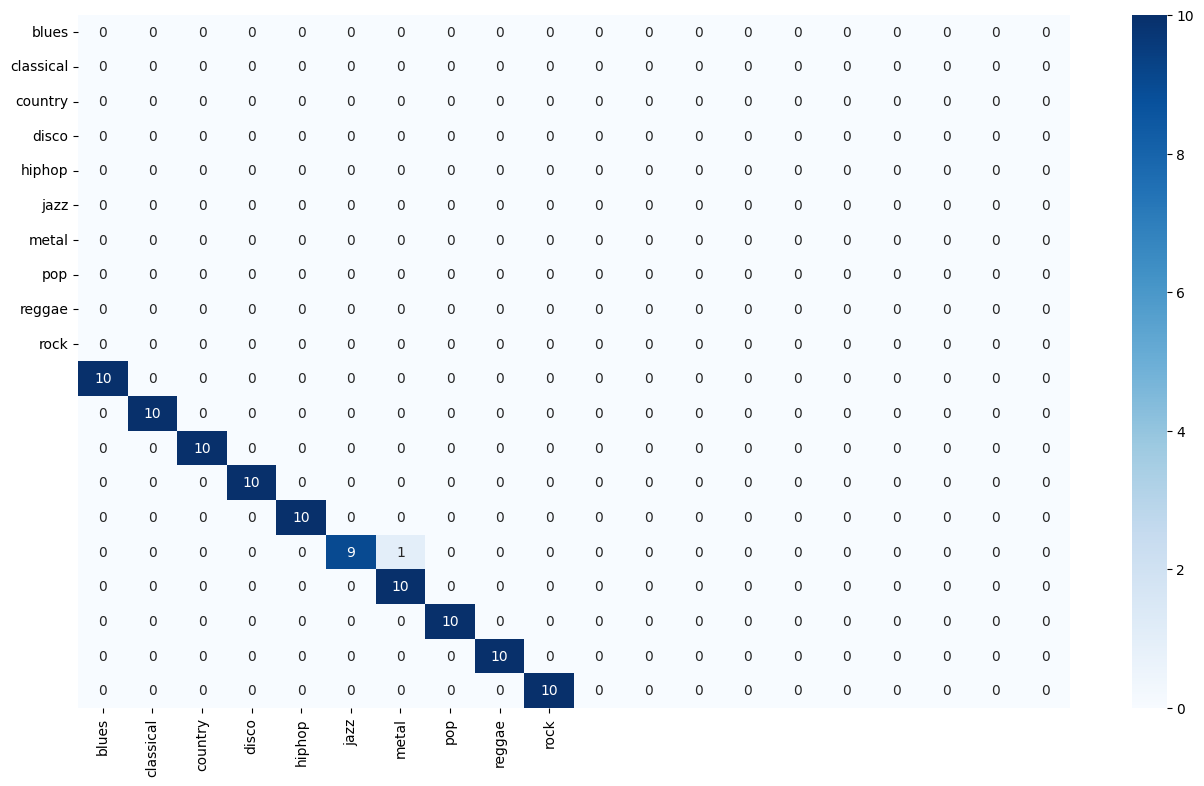

In [25]:
cm = confusion_matrix(pred["y"].astype(str), pred["PredictedLabel"].astype(str))
plt.figure(figsize = (16, 9))
sns.heatmap(cm,cmap="Blues", annot=True, xticklabels = target_names, yticklabels = target_names )

In [26]:
model1 = XGBClassifier(n_estimators=304, reg_lambda=25)
model1.fit(X_train,y_train,eval_metric='merror')
y_pred_test1 = model1.predict(X_test)
#printing accuracy
print(f"accuracy: {accuracy_score(y_test,y_pred_test1)}")
print(f'New tuned model:\n {classification_report(pred["y"].astype(str), pred["PredictedLabel"].astype(str), labels=target_names)}')

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:248: FutureWarning: Index.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.
  feature_names = data.columns.format()


accuracy: 0.0
New tuned model:
               precision    recall  f1-score   support

       blues       0.00      0.00      0.00      10.0
   classical       0.00      0.00      0.00      10.0
     country       0.00      0.00      0.00      10.0
       disco       0.00      0.00      0.00      10.0
      hiphop       0.00      0.00      0.00      10.0
        jazz       0.00      0.00      0.00      10.0
       metal       0.00      0.00      0.00      10.0
         pop       0.00      0.00      0.00      10.0
      reggae       0.00      0.00      0.00      10.0
        rock       0.00      0.00      0.00      10.0

   micro avg       0.00      0.00      0.00     100.0
   macro avg       0.00      0.00      0.00     100.0
weighted avg       0.00      0.00      0.00     100.0



/usr/local/lib/python3.10/dist-packages/xgboost/core.py:248: FutureWarning: Index.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.
  feature_names = data.columns.format()


In [27]:
pickle.dump(sc, open('sc.pkl','wb'))
pickle.dump(model1, open('model.pkl', 'wb'))